<a href="https://colab.research.google.com/github/aratrikchandra/CCTV-surveillance-for-traffic-dense-environments/blob/main/RandomForestClassifier/RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import re
import pandas as pd

In [2]:
# Importing necessary paackages

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.ensemble import RandomForestClassifier


seed = 5343

In [3]:
%%capture
#Get Original dataset
!mkdir -p data
!git clone 'https://github.com/shariqfz/Fake-News-Detection-Text-Classification.git'
!tar -zxvf '/content/Fake-News-Detection-Text-Classification/data/FakeNewsData.tar.gz'
!mv ./FakeNewsData/Fake.csv ./FakeNewsData/True.csv ./data
!rm -r /content/FakeNewsData /content/sample_data

In [4]:
true = pd.read_csv('/content/data/True.csv')
fake = pd.read_csv('/content/data/Fake.csv')

In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
# Introducing new column in both dataframes

true['impression']=1
fake['impression']=0

In [8]:
# Concatenating them using pandas concatenate to form a single dataframe

data_raw = pd.concat([true, fake], axis=0)
data_raw.sample(10)

,title,text,subject,date,impression
20536,NATIONAL SECURITY FOR SALE: UNIVISION Chair Gi...,Trump has the Left scrambling to figure out ho...,left-news,"May 23, 2016",0
11184,DID OBAMA ROB FANNIE & FREDDIE OF BILLIONS? Dr...,Dr. Ben Carson just found over $500 Billion mi...,politics,"Apr 7, 2017",0
3197,No hint of new gun control push in U.S. Congre...,WASHINGTON (Reuters) - There were prayers and ...,politicsNews,"June 14, 2017",1
13452,How To WATCH The Highly Anticipated ‘CLINTON C...,SHARE this link with everyone you know. EVERY ...,politics,"Jul 22, 2016",0
7656,U.S. House Speaker Ryan renews call to suspend...,WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"October 28, 2016",1
154,Senator McCain will vote on tax bill -No. 2 Re...,WASHINGTON (Reuters) - Republican Senator John...,politicsNews,"December 14, 2017",1
23149,SHIFTING PARADIGM: You’ll Only Understand Trum...,21st Century Wire says It s hard to not to dra...,Middle-east,"November 17, 2016",0
13875,LEADING N. CAROLINA NEWSPAPER: Girls Need To A...,The Leftist agenda in action blurring the line...,politics,"May 19, 2016",0
18796,SUPER BOWL CHAMP PLAYER Busts Into WH Press Br...,IT S INTERESTING THAT A LIGHTHEARTED MOMENT LI...,left-news,"Apr 19, 2017",0
20826,TWO MUSLIM UBER DRIVERS Charged With Multiple ...,Wow! We re fast becoming like Europe with the ...,left-news,"Mar 23, 2016",0


In [9]:
# Combining title and text to obtain a single string
# dropping title and

data_raw['fulltext'] = data_raw.title + ' ' + data_raw.text
data_raw.drop(['title','text'], axis=1, inplace=True)

In [10]:
# Extracting a new dataframe using features fulltext and impression
data = data_raw[['fulltext', 'impression']]
data = data.reset_index()
data.drop(['index'], axis=1, inplace=True)

In [11]:
# Check for missing values

data.isnull().sum()

fulltext      0
impression    0
dtype: int64

In [12]:
print('The dataset contans {} rows and {} columns'.format(data.shape[0], data.shape[1]))

The dataset contans 44898 rows and 2 columns


In [26]:
# Word extraction from true and fake texts

true_text = data[data.impression==1]['fulltext']
fake_text = data[data.impression==0]['fulltext']
fake_text = fake_text.reset_index().drop(['index'], axis=1)
true_text = true_text.reset_index().drop(['index'], axis=1)

In [ ]:
import nltk
nltk.download('all')


In [53]:
# Function to extract major words from true and fake news

def wordcloud_words(X_data_full):

    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2

    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full.iloc[i])
        X_data_full_clear_punct.append(test_data)

    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2

    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full.iloc[i])
        X_data_full_clear_stopwords.append(test_data)

    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words

    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full.iloc[i])
        X_data_full_tokenized_words.append(test_data)

    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words

    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full.iloc[i])
        X_data_full_lemmatized_words.append(test_data)

    return X_data_full_lemmatized_words

In [54]:
true_sample = true_text.sample(n=10000, random_state=1)
true_words = wordcloud_words(true_sample.fulltext)
fake_sample = fake_text.sample(n=10000, random_state=1)
fake_words = wordcloud_words(fake_sample.fulltext)

In [55]:
def plot_wordcloud(text):
    wordcloud = WordCloud(background_color = 'black',
                         max_words = 3000,
                         width=1600,
                         height=800).generate(text)
    plt.clf()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(true_words))

In [ ]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(fake_words))

In [22]:
# Sample 10k rows from the dataset
data_sample = data.sample(n=10000, random_state=1)
X_data = data_sample['fulltext'].astype(str)
y_data = data_sample['impression']

In [23]:
X_data.head(10)

4528     EPA chief says Paris climate agreement 'bad de...
31727    BREAKING NEWS: President Trump Announces Major...
10937    Trump says New Hampshire win not necessary to ...
13470    Kremlin: U.S. sanctions aimed at turning busin...
40814    MUST WATCH: Kellyanne Conway PUNCHES BACK Afte...
12702    Poland's PM designate says will continue fight...
2736     One more Republican defection would doom Senat...
31730    IT BEGINS: ANTHONY SCARAMUCCI FIRES Suspected ...
42479    Refugee Living In England Arrested For Threate...
26780     Cory Booker EVISCERATES RNC’s Hateful Tone, ‘...
Name: fulltext, dtype: object

In [35]:
# Function to retrieve processed words

def final(X_data_full):

    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2

    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full.iloc[i])
        X_data_full_clear_punct.append(test_data)

    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2

    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full.iloc[i])
        X_data_full_clear_stopwords.append(test_data)

    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words

    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full.iloc[i])
        X_data_full_tokenized_words.append(test_data)

    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words

    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full.iloc[i])
        X_data_full_lemmatized_words.append(test_data)

    # creating the bag of words model
    cv = CountVectorizer(max_features=1000)
    X_data_full_vector = cv.fit_transform(X_data_full_lemmatized_words).toarray()


    tfidf = TfidfTransformer()
    X_data_full_tfidf = tfidf.fit_transform(X_data_full_vector).toarray()

    return X_data_full_tfidf

In [36]:
# Setting the function with parameters

data_X = final(X_data)

In [37]:
# Preparing training and testing data using train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_X, y_data, test_size=0.20, random_state= seed)

In [38]:
# Fitting the model and making prediction

rfc=RandomForestClassifier(n_estimators= 10, random_state= seed)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)

In [51]:
# Finding Classification report

print(classification_report(y_test, predictions))

rfc_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
rfc_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , rfc_accuracy , " %")
print("f1_score : " , rfc_f1)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1310
           1       0.99      0.98      0.99      1190

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500

Accuracy :  98.68  %
f1_score :  0.987


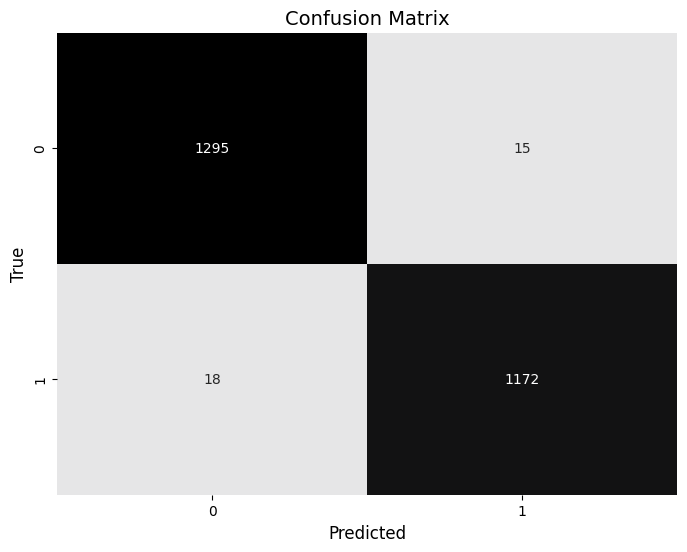

In [42]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Define a custom color palette
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0)

# Create a heatmap with custom styling
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=rfc.classes_, yticklabels=rfc.classes_)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [58]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    # Add other hyperparameters to tune
}


In [59]:
rfc = RandomForestClassifier(random_state=seed)
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy')


In [60]:
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5343),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy')

In [61]:
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_accuracy)


Best Hyperparameters:  {'max_depth': None, 'n_estimators': 200}
Best Accuracy:  0.9958666666666666


In [62]:
best_rfc = grid_search.best_estimator_
predictions = best_rfc.predict(X_test)

# Evaluate the best model
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

rfc_f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
rfc_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy: ", rfc_accuracy, " %")
print("F1 Score: ", rfc_f1)


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1310
           1       0.99      0.99      0.99      1190

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500

[[1303    7]
 [   6 1184]]
Accuracy:  99.48  %
F1 Score:  0.995


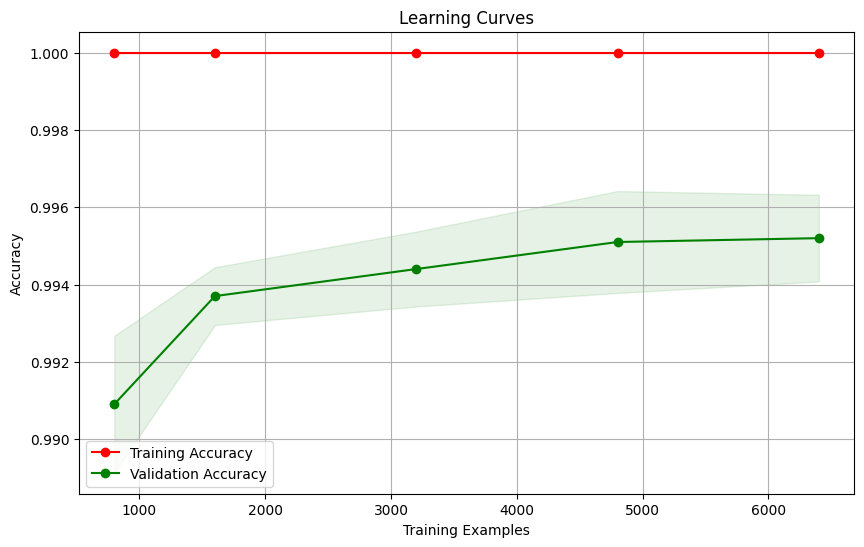

In [63]:
from sklearn.model_selection import learning_curve

# Define the RandomForestClassifier with the best hyperparameters (from GridSearchCV)
best_rfc = grid_search.best_estimator_

# Create learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    best_rfc, data_X, y_data, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8], cv=5, scoring='accuracy'
)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_mean = validation_scores.mean(axis=1)
validation_scores_std = validation_scores.std(axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.title("Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Validation Accuracy")

plt.legend(loc="best")
plt.show()
